# Stock NeurIPS2018 Part 3. Backtest
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the third and last part of the NeurIPS2018 series, introducing how to use use the agents we trained to do backtest, and compare with baselines such as Mean Variance Optimization and DJIA index.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [2]:
train = pd.read_csv('train_data_dow30_1989-01-01_2022-07-01.csv')
trade = pd.read_csv('trade_data_dow30_2022-07-01_2024-10-29.csv')

In [3]:
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
,,,,,,,,,,,,,,,,,
0,2022-07-01,AAPL,137.066147,138.929993,139.039993,136.039993,71051600.0,4.0,-2.506138,150.354667,127.362333,42.668917,-44.566334,2.993118,140.091666,150.219833,29.530001
0,2022-07-01,AMGN,227.034637,245.550003,246.000000,243.250000,2745500.0,4.0,-0.201872,251.918793,231.317207,50.801379,-7.106816,16.362315,244.750333,244.900167,29.530001
0,2022-07-01,AXP,136.196823,140.399994,140.889999,138.070007,2625300.0,4.0,-6.402676,171.878342,128.274658,39.107922,-101.181040,23.290635,153.768333,164.204167,29.530001
0,2022-07-01,BA,139.839996,139.839996,141.789993,135.880005,7627100.0,4.0,-0.173603,147.371193,121.357809,45.537900,68.296219,1.123293,131.727001,145.710167,29.530001
0,2022-07-01,CAT,169.630936,178.289993,181.320007,179.309998,3423100.0,4.0,-8.420835,234.739145,168.980853,37.696671,-137.268271,31.974925,204.527999,210.235999,29.530001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2024-10-25,TRV,250.500000,250.500000,257.399994,257.309998,942300.0,4.0,7.545260,270.832537,217.118464,61.945197,97.029254,18.669475,242.373000,231.965833,19.219999
583,2024-10-25,UNH,564.559998,564.559998,571.500000,566.159973,2513700.0,4.0,-4.788629,609.836457,548.415533,48.361730,-93.539029,10.035612,579.122329,581.195831,19.219999
583,2024-10-25,VZ,41.380001,41.380001,42.180000,41.900002,19717400.0,4.0,-0.299102,45.693344,41.572658,46.303429,-216.077122,5.430581,43.884667,42.602334,19.219999


Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [4]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

Load the agents

In [5]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + '/agent_a2c') if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [6]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 25, State Space: 251


In [7]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [8]:
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold=70, risk_indicator_col='vix',**env_kwargs)

In [9]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment= e_trade_gym
) if if_using_a2c else (None, None)

hit end!


In [10]:
df_account_value_a2c

,date,account_value
0,2022-07-01,1.000000e+06
1,2022-07-05,9.994686e+05
2,2022-07-06,9.998480e+05
3,2022-07-07,1.004066e+06
4,2022-07-08,1.003341e+06
...,...,...
579,2024-10-21,1.497648e+06
580,2024-10-22,1.481436e+06
581,2024-10-23,1.477921e+06
582,2024-10-24,1.461013e+06


In [11]:
df_actions_a2c

,AAPL,AMGN,AXP,BA,CAT,CVX,DIS,HD,HON,IBM,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0,0,0,100,25,0,0,0,0,0,...,12,0,47,0,0,94,58,27,30,0
2022-07-05,0,0,0,100,25,0,0,0,0,0,...,12,0,47,0,0,94,58,27,30,0
2022-07-06,0,0,0,100,25,0,0,0,0,0,...,12,0,47,0,0,94,58,27,30,0
2022-07-07,0,0,0,100,25,0,0,0,0,0,...,12,0,47,0,0,94,58,27,30,0
2022-07-08,0,0,0,100,25,0,0,0,0,0,...,12,0,47,0,0,94,58,27,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [13]:
df_account_value_ddpg

,date,account_value
0,2022-07-01,1.000000e+06
1,2022-07-05,9.991212e+05
2,2022-07-06,1.000719e+06
3,2022-07-07,1.007401e+06
4,2022-07-08,1.007484e+06
...,...,...
579,2024-10-21,1.263158e+06
580,2024-10-22,1.258131e+06
581,2024-10-23,1.259884e+06
582,2024-10-24,1.241944e+06


In [14]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [15]:
df_account_value_ppo

,date,account_value
0,2022-07-01,1.000000e+06
1,2022-07-05,9.997368e+05
2,2022-07-06,1.000017e+06
3,2022-07-07,1.000953e+06
4,2022-07-08,1.001726e+06
...,...,...
579,2024-10-21,1.168799e+06
580,2024-10-22,1.168981e+06
581,2024-10-23,1.156165e+06
582,2024-10-24,1.138168e+06


In [16]:
df_actions_ppo

,AAPL,AMGN,AXP,BA,CAT,CVX,DIS,HD,HON,IBM,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0,12,51,21,5,21,14,8,24,34,...,18,0,0,4,0,0,16,0,5,19
2022-07-05,0,12,51,21,5,21,14,8,24,34,...,18,0,0,4,0,0,16,0,5,19
2022-07-06,0,12,51,21,5,21,14,8,24,34,...,18,0,0,4,0,0,16,0,5,19
2022-07-07,0,12,51,21,5,21,14,8,24,34,...,18,0,0,4,0,0,16,0,5,19
2022-07-08,0,12,51,21,5,21,14,8,24,34,...,18,0,0,4,0,0,16,0,5,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [18]:
df_account_value_td3

,date,account_value
0,2022-07-01,1.000000e+06
1,2022-07-05,9.990535e+05
2,2022-07-06,9.991087e+05
3,2022-07-07,1.007077e+06
4,2022-07-08,1.006381e+06
...,...,...
579,2024-10-21,1.383177e+06
580,2024-10-22,1.373028e+06
581,2024-10-23,1.358314e+06
582,2024-10-24,1.347572e+06


In [19]:
df_actions_td3

,AAPL,AMGN,AXP,BA,CAT,CVX,DIS,HD,HON,IBM,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0,100,0,0,100,0,0,0,100,100,...,100,100,0,0,0,100,100,100,100,100
2022-07-05,0,100,0,0,100,0,0,0,100,100,...,100,100,0,0,0,100,100,100,100,100
2022-07-06,0,100,0,0,100,0,0,0,100,100,...,100,100,0,0,0,100,100,100,100,100
2022-07-07,0,100,0,0,100,0,0,0,100,100,...,100,100,0,0,0,100,100,100,100,100
2022-07-08,0,100,0,0,100,0,0,0,100,100,...,100,77,0,0,0,0,0,1,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


In [21]:
df_account_value_sac

,date,account_value
0,2022-07-01,1.000000e+06
1,2022-07-05,1.000066e+06
2,2022-07-06,1.004696e+06
3,2022-07-07,1.005994e+06
4,2022-07-08,1.012194e+06
...,...,...
579,2024-10-21,1.330055e+06
580,2024-10-22,1.308479e+06
581,2024-10-23,1.299100e+06
582,2024-10-24,1.296812e+06


In [22]:
df_actions_sac

,AAPL,AMGN,AXP,BA,CAT,CVX,DIS,HD,HON,IBM,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,100,100,100,100,0,100,0,100,0,0,...,0,0,0,100,100,0,0,0,100,0
2022-07-05,100,100,100,100,0,100,0,100,0,0,...,0,0,0,100,100,0,0,0,100,0
2022-07-06,100,100,100,100,0,100,0,100,0,0,...,0,0,0,100,100,0,0,0,100,0
2022-07-07,100,100,100,100,0,100,0,100,0,0,...,0,0,0,100,100,0,0,0,100,0
2022-07-08,100,100,100,100,0,100,0,100,0,0,...,0,0,0,100,100,0,0,0,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [38]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

### Helper functions for mean returns and variance-covariance matrix

In [39]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [40]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[136.03999329, 243.25      , 138.07000732, ...,  50.95999908,
         37.63000107,  40.64666748],
       [137.77000427, 245.19000244, 137.22000122, ...,  51.41999817,
         37.91999817,  40.73666763],
       [141.3500061 , 246.61999512, 139.28999329, ...,  51.41999817,
         38.38999939,  41.49333191],
       ...,
       [234.08000183, 316.01000977, 272.        , ...,  41.86000061,
          9.68000031,  81.88999939],
       [229.97999573, 314.42999268, 270.23001099, ...,  42.38000107,
          9.39000034,  82.95999908],
       [229.74000549, 318.48999023, 271.6499939 , ...,  41.90000153,
          9.36999989,  83.19999695]])

In [41]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.114 0.091 0.057 0.045 0.059 0.039 0.045 0.082 0.056 0.037 0.072 0.048
 0.058 0.04  0.053 0.033 0.039 0.094 0.08  0.044 0.045   nan 0.02  0.048
 0.051]
Variance-Covariance matrix of returns
 [[7.931 1.699 1.952 1.367 1.514 0.925 1.486 1.972 1.59  1.853 3.056 0.85
  2.178 0.799 1.144 1.005 0.983 2.401 1.462 0.749 1.098   nan 0.852 1.15
  1.302]
 [1.699 4.883 1.457 0.96  1.016 0.743 1.02  1.459 1.118 1.215 1.747 1.116
  1.569 0.808 0.887 0.798 1.265 1.68  1.029 0.828 0.982   nan 0.867 1.026
  1.054]
 [1.952 1.457 4.73  1.932 1.937 1.366 1.818 2.068 1.948 1.543 2.023 1.039
  3.232 1.065 1.309 1.337 1.24  1.761 1.67  0.973 1.739   nan 1.206 1.366
  1.346]
 [1.367 0.96  1.932 4.239 1.684 1.214 1.553 1.522 1.8   1.141 1.425 0.737
  1.857 0.888 1.041 1.12  0.863 1.23  1.376 0.673 1.293   nan 0.77  1.095
  0.877]
 [1.514 1.016 1.937 1.684 3.879 1.347 1.485 1.563 1.843 1.26  1.602 0.763
  2.074 0.827 0.952 1.321 0.868 1.312 1.349 0.733 1.284   nan 0.89

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_61823/3211158930.py:10: RuntimeWarning: invalid value encountered in scalar divide
  StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100
/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_61823/3211158930.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100


### Use PyPortfolioOpt

In [42]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
mvo_weights

ValueError: Quadratic form matrices must be symmetric/Hermitian.

In [43]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

NameError: name 'mvo_weights' is not defined

In [44]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

NameError: name 'Initial_Portfolio' is not defined

# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [23]:
TRAIN_START_DATE = '1989-01-01'
TRAIN_END_DATE = '2022-07-01'
TRADE_START_DATE = '2022-07-01'
TRADE_END_DATE = '2024-10-29'

In [25]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["^dji"]
).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (585, 8)


In [26]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")
dji

,close
date,
2022-07-01,1.000000e+06
2022-07-05,1.005379e+06
2022-07-06,1.007142e+06
2022-07-07,1.014734e+06
2022-07-08,1.019867e+06
...,...
2024-10-22,1.394924e+06
2024-10-23,1.393543e+06
2024-10-24,1.383397e+06


# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [30]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

## a2c backtest result

In [28]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)

result_a2c = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "dji": dji["close"],
    }
)
result_a2c

,a2c,dji
date,,
2022-07-01,1.000000e+06,1.000000e+06
2022-07-05,9.994686e+05,1.005379e+06
2022-07-06,9.998480e+05,1.007142e+06
2022-07-07,1.004066e+06,1.014734e+06
2022-07-08,1.003341e+06,1.019867e+06
...,...,...
2024-10-22,1.481436e+06,1.394924e+06
2024-10-23,1.477921e+06,1.393543e+06
2024-10-24,1.461013e+06,1.383397e+06


<Axes: xlabel='date'>

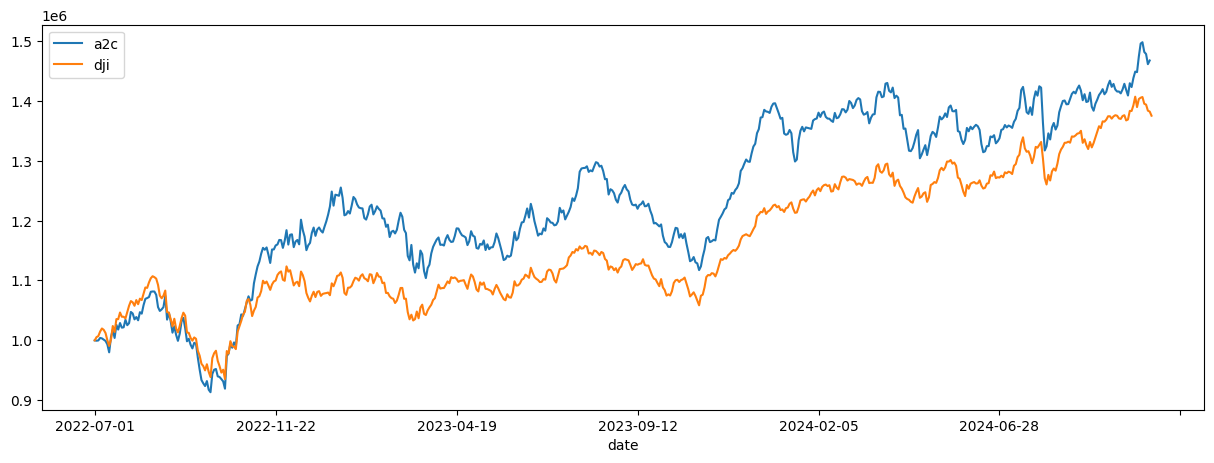

In [31]:
result_a2c.plot()

## ddpg backtest result

In [32]:
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
result_ddpg = pd.DataFrame(
    {
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "dji": dji["close"],
    }
)


<Axes: xlabel='date'>

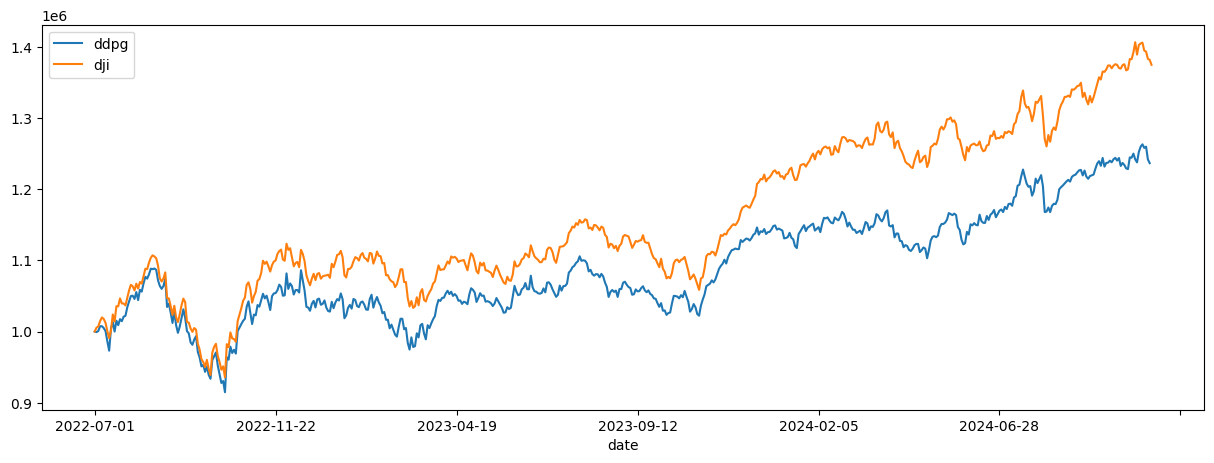

In [33]:
result_ddpg.plot()

## ppo backtest result

In [34]:
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
result_ppo = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "dji": dji["close"],
    }
)


<Axes: xlabel='date'>

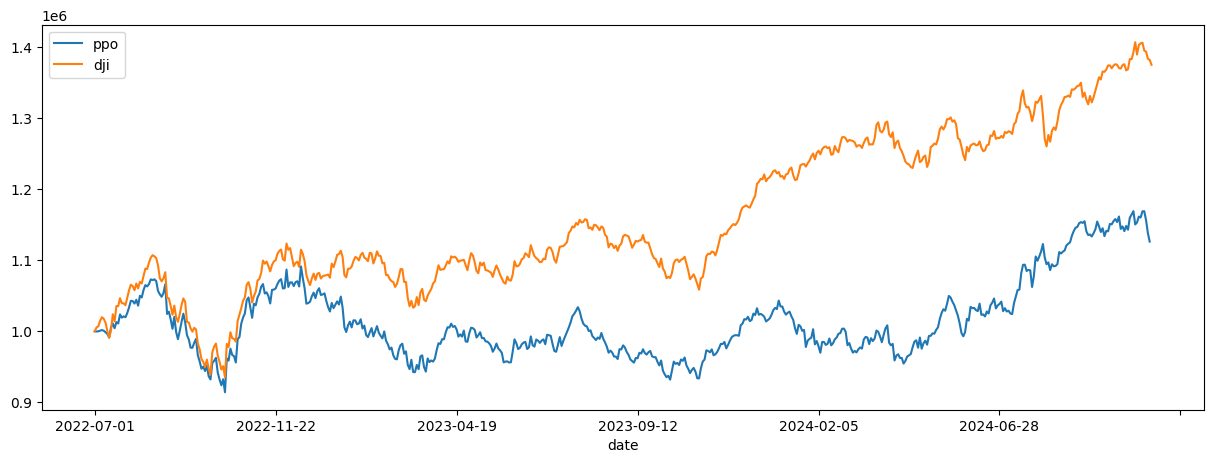

In [35]:
result_ppo.plot()

## td3 backtest result

In [36]:
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
result_td3 = pd.DataFrame(
    {
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "dji": dji["close"],
    }
)

<Axes: xlabel='date'>

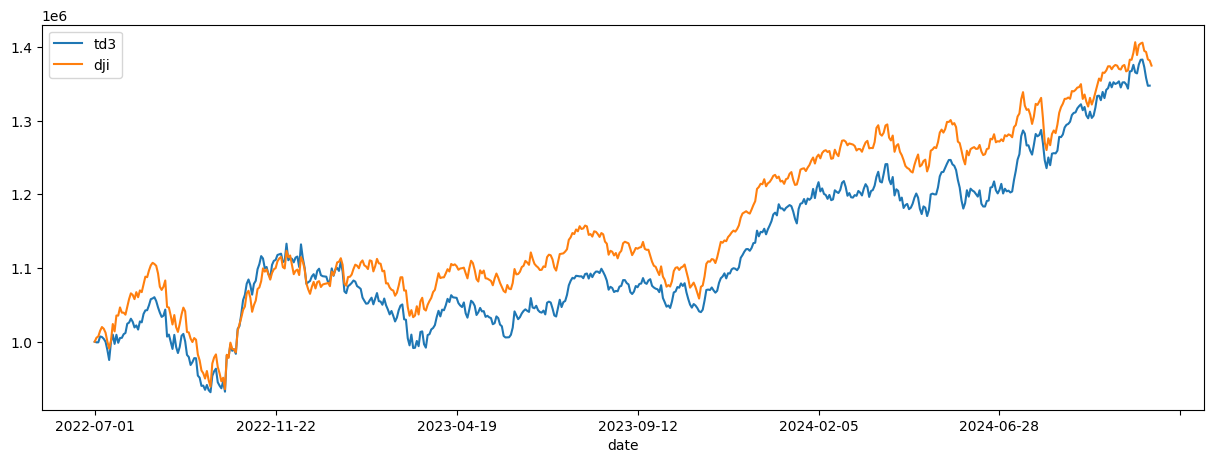

In [37]:
result_td3.plot()

## sac backtest result

In [38]:
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)
result_sac =  pd.DataFrame(
    {
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "dji": dji["close"],
    }
)

<Axes: xlabel='date'>

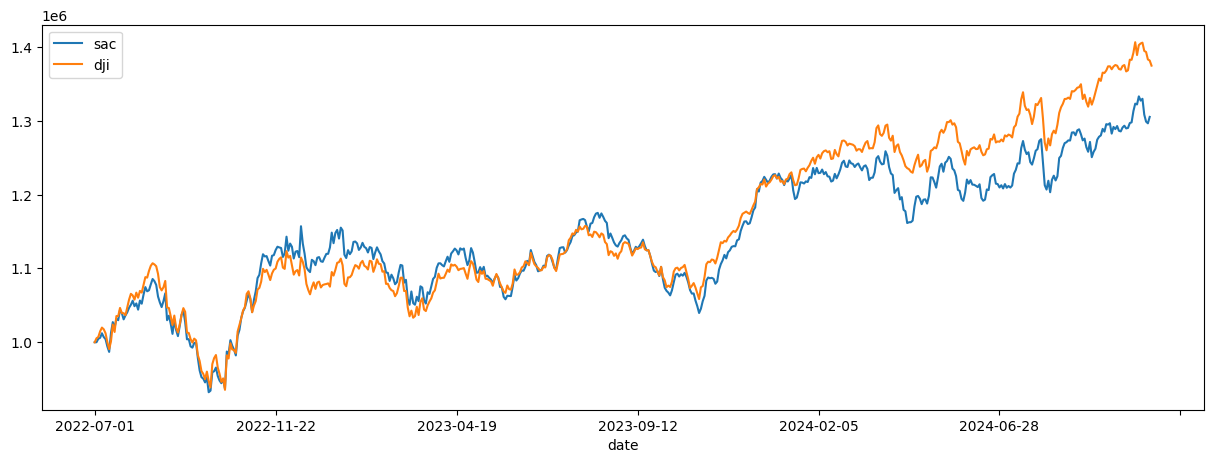

In [39]:
result_sac.plot()